In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Project 2

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Project 2


###Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

###Load and process data

In [ ]:
valid = np.load('valid_periods.npy')
valid = pd.DataFrame.from_dict(valid)
print(valid.shape)

(48000, 2)


In [ ]:
categories = np.load('categories.npy')
categories = pd.DataFrame.from_dict(categories)
print(categories.shape)

(48000, 1)


In [ ]:
dataset = np.load('training_data.npy')
# To have lighter processes
dataset = dataset.astype(np.float32)
# Convert into pandas dataframe
dataset = pd.DataFrame.from_dict(dataset)
print(dataset.shape)

(48000, 2776)


In [ ]:
transposed_dataset = dataset.T
print(transposed_dataset.shape)

(2776, 48000)


In [ ]:
# Count numbers per categories
A = categories[0].value_counts()
print(A)

B    10987
E    10975
C    10017
D    10016
A     5728
F      277
Name: 0, dtype: int64


In [ ]:
# First occurence for each category
idxA = 20991
idxB = 36736
idxC = 26719
idxD = 0
idxE = 10016
idxF = 47723

In [ ]:
# Select first 100 samples per category
idxsA = np.arange(20991, 20991+100)
idxsB = np.arange(36736, 36736+100)
idxsC = np.arange(26719, 26719+100)
idxsD = np.arange(0, 100)
idxsE = np.arange(10016, 10016+100)
idxsF = np.arange(47723, 47723+100)

In [ ]:
new_dataset = dataset.iloc[idxsD]
new_dataset = new_dataset.append(dataset.iloc[idxsE])
new_dataset = new_dataset.append(dataset.iloc[idxsA])
new_dataset = new_dataset.append(dataset.iloc[idxsC])
new_dataset = new_dataset.append(dataset.iloc[idxsB])
new_dataset = new_dataset.append(dataset.iloc[idxsF])

new_dataset.shape

(600, 2776)

In [ ]:
# Function to replace zeros in time series based on non-zero indices
def replace_zeros(row):
    non_zero_idx = valid.iloc[row.name, 1]  # Assuming the non-zero index column is at index 1
    row[:non_zero_idx] = row[:non_zero_idx].replace(0, your_number_to_replace)
    return row

# Replace 0 with another number
your_number_to_replace = 2  # Replace 0 with -1 for example

# Apply the function row-wise to replace zeros in time series DataFrame
new_dataset = new_dataset.apply(replace_zeros, axis=1)

In [ ]:
# Identify columns where all values are equal to 2
cols_to_drop = [col for col in new_dataset.columns if new_dataset[col].eq(2).all()]

# delete this columns
new_dataset = new_dataset.drop(columns=cols_to_drop)
print(new_dataset.shape)

(600, 900)


In [ ]:
new_trans = new_dataset.T
new_trans.shape

(900, 600)

###Train test splitting

In [ ]:
window=200
stride=10
direct_telescope=18

In [ ]:
def build_sequences_batched(df, window=200, stride=5, telescope=9, batch_size=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0

    # Use NumPy view instead of creating a copy
    temp_df = df.copy()

    # Check if padding is needed
    padding_check = len(df) % window
    series_count = temp_df.shape[1]

    if padding_check != 0:
        # Compute padding length
        padding_len = window - len(df) % window
        temp_df = np.pad(temp_df, ((padding_len, 0), (0, 0)), mode='constant', constant_values=0)

    # Initialize arrays for X_train and y_train
    X_train_batches = []
    y_train_batches = []

    # Loop through each series in the dataframe
    for series_idx in range(series_count):
        series_data = temp_df[:, series_idx]

        # Create arrays in chunks and append to batches
        window_data_chunks = [series_data[i:i+window] for i in range(0, len(series_data) - window - telescope, stride)]
        target_values_chunks = [series_data[i+window:i+window+telescope] for i in range(0, len(series_data) - window - telescope, stride)]

        X_train_batches.extend(np.array_split(window_data_chunks, batch_size))
        y_train_batches.extend(np.array_split(target_values_chunks, batch_size))

    # Concatenate batches
    X_train = np.concatenate(X_train_batches, axis=0)[:, np.newaxis, :]
    y_train = np.concatenate(y_train_batches, axis=0)[:, np.newaxis, :]

    return X_train, y_train

In [ ]:
X_train, y_train = build_sequences_batched(new_trans, window, stride, direct_telescope)
X_train.shape, y_train.shape

In [ ]:
X_train = X_train.reshape(48000, 200, 1)
y_train = y_train.reshape(48000, 9, 1)
X_train.shape, y_train.shape

###Model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
print(input_shape, output_shape)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a masking layer
    x = tfkl.Masking(mask_value=2.0, name='masking')(input_layer)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    x = tf.keras.layers.Flatten()(x)

    # Add a Dense layer to match the required output shape
    x = tf.keras.layers.Dense(output_shape[0] * output_shape[1])(x)

    # Reshape to match the desired output shape
    x = tf.keras.layers.Reshape(output_shape, name='reshape')(x)

    # Remove the last dimension
    output_layer = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
600/600 [==============================] - 279s 432ms/step - loss: 0.0888 - val_loss: 0.0285 - lr: 0.0010
Epoch 2/200
600/600 [==============================] - 248s 414ms/step - loss: 0.0312 - val_loss: 0.0305 - lr: 0.0010
Epoch 3/200
600/600 [==============================] - 245s 409ms/step - loss: 0.0302 - val_loss: 0.0270 - lr: 0.0010
Epoch 4/200
600/600 [==============================] - 245s 409ms/step - loss: 0.0301 - val_loss: 0.0256 - lr: 0.0010
Epoch 5/200
600/600 [==============================] - 256s 426ms/step - loss: 0.0300 - val_loss: 0.0251 - lr: 0.0010
Epoch 6/200
600/600 [==============================] - 249s 415ms/step - loss: 0.0290 - val_loss: 0.0248 - lr: 0.0010
Epoch 7/200
600/600 [==============================] - 254s 424ms/step - loss: 0.0291 - val_loss: 0.0253 - lr: 0.0010
Epoch 8/200
600/600 [==============================] - 245s 409ms/step - loss: 0.0287 - val_loss: 0.0250 - lr: 0.0010
Epoch 9/200
600/600 [==============================] - 2

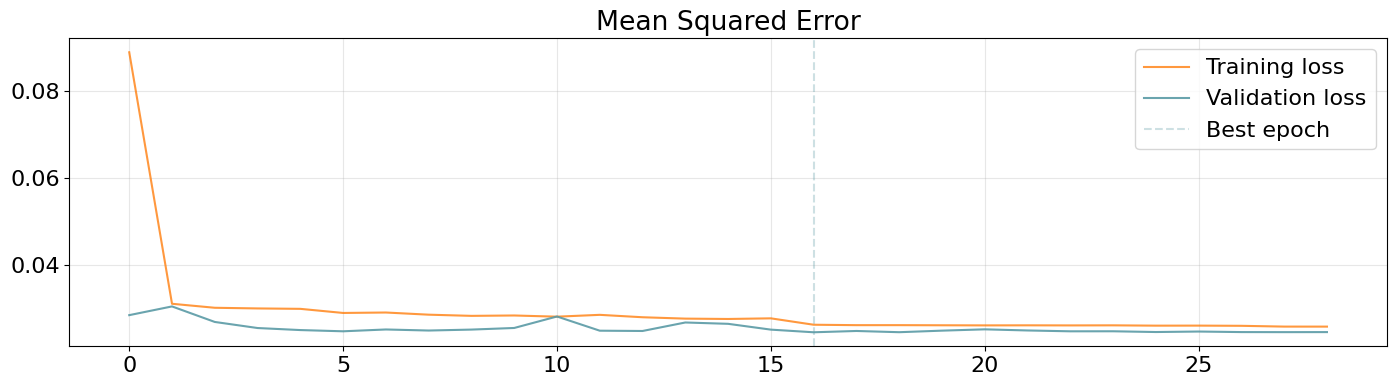

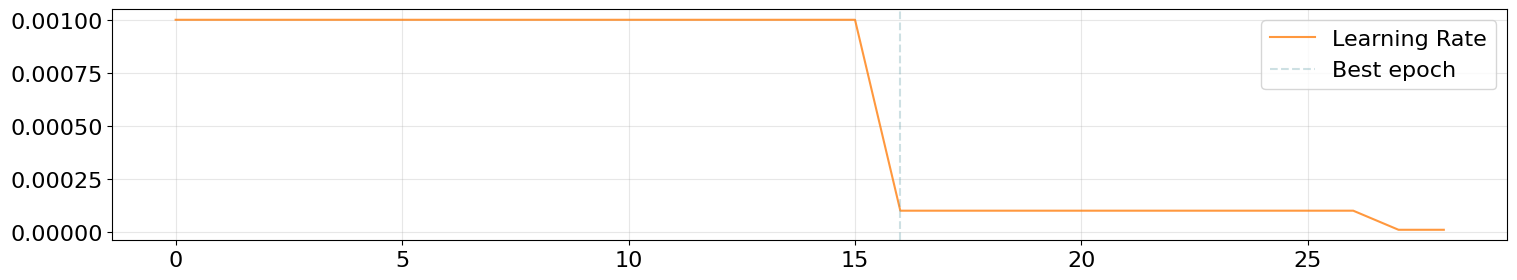

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('provaFede2')